In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import scanorama
import anndata
import scipy
import os

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

In [3]:
def load_breast_layer(path):
    X = pd.read_csv(path, delimiter = '\t', index_col= 0)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [4]:
layer1_path = "../breast_cancer_data/Layer1_BC_count_matrix-1.tsv"
layer2_path = "../breast_cancer_data/Layer2_BC_count_matrix-1.tsv"
layer3_path = "../breast_cancer_data/Layer3_BC_count_matrix-1.tsv"
layer4_path = "../breast_cancer_data/Layer4_BC_count_matrix-1.tsv"

adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

In [5]:
slices = {
    "SliceA" : adata_layer_1,
    "SliceB" : adata_layer_2,
    "SliceC" : adata_layer_3,
    "SliceD" : adata_layer_4
}

path_to_output_dir = '../data/Stahl-BC/cached-results/non-zero-count/'

if not os.path.exists(path_to_output_dir):
    os.makedirs(path_to_output_dir)

In [6]:
pseudocounts = [0, 0.1, 0.2, 0.5, 1, 2]

In [7]:
for slice_name, adata in slices.items():
    base_layer = adata.copy()
    a = base_layer.X
    num_genes = a.shape[1]
    b = np.count_nonzero(a, axis = 1)/num_genes
    df = pd.DataFrame({'original': b})
    for p in pseudocounts:
        a = simulate_gene_exp(adata, p).X
        num_genes = a.shape[1]
        b = np.count_nonzero(a, axis = 1)/num_genes
        df['pc = ' + str(p)] = b
    df.to_csv(path_to_output_dir + slice_name + '-percent-nonzero.csv')

Plot Results

In [3]:
path_to_output_dir = '../data/Stahl-BC/cached-results/non-zero-count/'

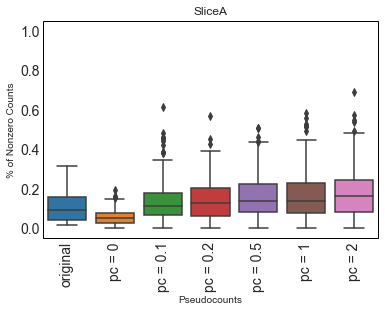

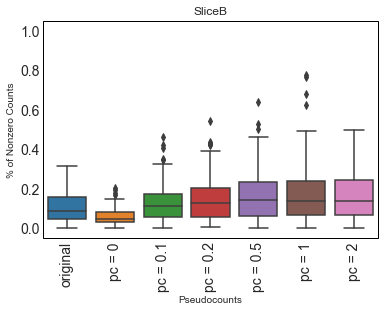

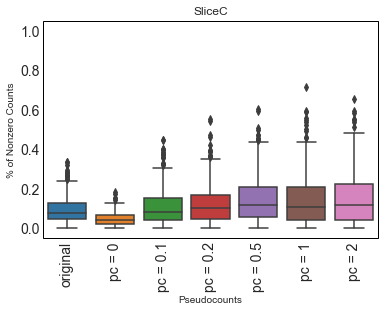

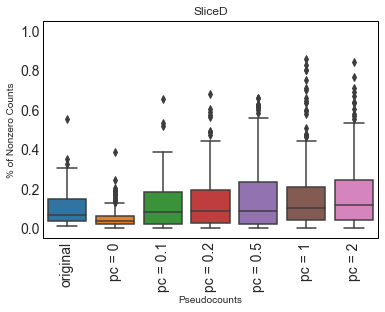

In [4]:
for slice_name in ['SliceA', 'SliceB', 'SliceC', 'SliceD']:
    df = pd.read_csv(path_to_output_dir + slice_name + '-percent-nonzero.csv', index_col = 0)
    # Distribution of Nonzero Counts
    ax = sns.boxplot(data= df)
    ax.set(ylim=(-0.05,1.05))
    ax.set_facecolor('white')
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth('1')  
    ax.set(xlabel='Pseudocounts', ylabel='% of Nonzero Counts')
    ax.set_title(slice_name)
    plt.xticks(rotation = 90)
    # plt.savefig('reasonable_pc_sliceA.pdf', dpi = 300, bbox_inches = "tight")
    plt.show()